Intro:
*   Author: Santanam Wishal
*   Project: Machine Learning - Image Classification
*   Email: santawishal17@gmail.com
*   LinkedIn: www.linkedin.com/in/santawishal
*   GitHub: https://github.com/kianaaa19/




Image Classification Model Deployment

In [ ]:
# Import dependencies
!pip install opencv-python
!pip install -q kaggle
import pandas as pd
import numpy as np
import cv2
import os
import zipfile
import shutil
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from google.colab import files
from google.colab.patches import cv2_imshow
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.applications import VGG16
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Activation, Add, Dropout, BatchNormalization, Flatten, Conv2D, MaxPooling2D, Dense, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

Dataset: UTKFaces (20.000+ pictures, Different Resolution)

Link: https://www.kaggle.com/datasets/jangedoo/utkface-new

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"santanamwishal","key":"61a131d0b4dd2cf8b185edc2e6746eec"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d jangedoo/utkface-new

 91% 301M/331M [00:01<00:00, 270MB/s]
100% 331M/331M [00:01<00:00, 263MB/s]


In [ ]:
zipPath = '../content/utkface-new.zip'
zipFile = zipfile.ZipFile(zipPath, 'r')
zipFile.extractall('../content/UTKFACE')
zipFile.close()

In [ ]:
train_dir = os.path.join('../content/UTKFACE/UTKFace')

In [ ]:
# Load Dataset
path = train_dir
pixels = []
gender = []
i=0
for img in os.listdir(path):
  i=i+1
  genders = img.split("_")[1]
  img = cv2.imread(str(path)+"/"+str(img))
  img=cv2.resize(img,(64,64))
  pixels.append(np.array(img))
  gender.append(np.array(genders))
pixels = np.array(pixels)
gender = np.array(gender,np.uint64)

In [ ]:
# Split Dataset into 80:20 training & test
x_train,x_test,y_train,y_test = train_test_split(pixels,gender,test_size=0.2,random_state=100)

In [ ]:
print(len(x_train))
print(len(x_test))

18966
4742


In [ ]:
# Transfer Learning VGG16
base_model = VGG16(input_shape=(64,64,3),include_top=False,weights="imagenet")

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
# Freezing Layers
for layer in base_model.layers[:-20]:
    layer.trainable=False

In [ ]:
# CNN Architecture
model=Sequential()
model.add(base_model)
model.add(layers.Dropout(.2))
model.add(Conv2D(512, (3, 3),strides=(1,1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(layers.Dropout(.1))
model.add(Conv2D(128, (3, 3),strides=(1,1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(layers.Dropout(.1))
model.add(Conv2D(384, (3, 3),strides=(1,1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(layers.Dropout(.1))
model.add(Conv2D(384, (3, 3),strides=(1,1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(layers.Dropout(.1))
model.add(Conv2D(500, (3, 3),strides=(1,1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,strides=(2,2), padding='same'))
model.add(Flatten())
model.add(Dense(2048 , activation='relu'))
model.add(layers.Dropout(.2))
model.add(Dense(2048 , activation='relu'))
model.add(layers.Dropout(.2))
model.add(Dense(2048, activation='relu'))
model.add(layers.Dropout(.2))
model.add(Dense(2, activation='sigmoid'))

In [ ]:
# Model compile
opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt,loss=["sparse_categorical_crossentropy"],metrics=['mae','accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 dropout (Dropout)           (None, 2, 2, 512)         0         
                                                                 
 conv2d (Conv2D)             (None, 2, 2, 512)         2359808   
                                                                 
 batch_normalization (Batch  (None, 2, 2, 512)         2048      
 Normalization)                                                  
                                                                 
 dropout_1 (Dropout)         (None, 2, 2, 512)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 2, 2, 128)         589952    
                                                        

In [ ]:
# Callback Function
class myCallback(Callback):
   def on_epoch_end(self, epoch, logs={}):
        if((logs.get('accuracy') >= target and logs.get('val_accuracy') >= target) and epoch >= 3):
            print(f"\nAkurasi dan Validation Accuration sudah mencapai 92%", "\nEpoch: ", epoch)
            self.model.stop_training = True
target = 0.92
callbacks = myCallback()

In [ ]:
# Model Checkpoint
model_path='../content/model.h5'
checkpointer = ModelCheckpoint(model_path, monitor='loss',verbose=1,save_best_only=True,
                               save_weights_only=False, mode='auto',save_freq='epoch')

In [ ]:
# Auto Reduction
auto_reduction = ReduceLROnPlateau(
    monitor = 'val_accuracy',
    patience = 3,
    verbose = 1,
    factor = 0.5,
    min_lr = 0.0001
)

In [ ]:
# Auto Stop Learn
auto_stop_learn = EarlyStopping(
    monitor = 'val_accuracy',
    min_delta = 0,
    patience = 4,
    verbose = 1,
    mode = 'auto'
)

In [ ]:
save = model.fit(x_train,
                 y_train,
                 validation_data=(x_test,y_test),
                 epochs=15,
                 steps_per_epoch=64,
                 validation_steps=64,
                 callbacks=[callbacks,checkpointer,auto_reduction,auto_stop_learn])

Epoch 1/15
 6/64 [=>............................] - ETA: 23s - loss: 1.0896 - mae: 0.5002 - accuracy: 0.4989

64/64 [==============================] - ETA: 0s - loss: 0.5498 - mae: 0.4964 - accuracy: 0.7264
Epoch 1: loss improved from inf to 0.54976, saving model to ../content/model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


64/64 [==============================] - 92s 915ms/step - loss: 0.5498 - mae: 0.4964 - accuracy: 0.7264 - val_loss: 0.6130 - val_mae: 0.5012 - val_accuracy: 0.7410 - lr: 1.0000e-04
Epoch 2/15
64/64 [==============================] - ETA: 0s - loss: 0.2580 - mae: 0.4930 - accuracy: 0.8947
Epoch 2: loss improved from 0.54976 to 0.25802, saving model to ../content/model.h5
64/64 [==============================] - 29s 458ms/step - loss: 0.2580 - mae: 0.4930 - accuracy: 0.8947 - val_loss: 0.3803 - val_mae: 0.5052 - val_accuracy: 0.8950 - lr: 1.0000e-04
Epoch 3/15
64/64 [==============================] - ETA: 0s - loss: 0.2153 - mae: 0.4923 - accuracy: 0.9126
Epoch 3: loss improved from 0.25802 to 0.21532, saving model to ../content/model.h5
64/64 [==============================] - 33s 517ms/step - loss: 0.2153 - mae: 0.4923 - accuracy: 0.9126 - val_loss: 0.3149 - val_mae: 0.4965 - val_accuracy: 0.8623 - lr: 1.0000e-04
Epoch 4/15
64/64 [==============================] - ETA: 0s - loss: 0.187

Text(0.5, 0.92, 'Lineplots showing loss and accuracy of CNN model by epochs')

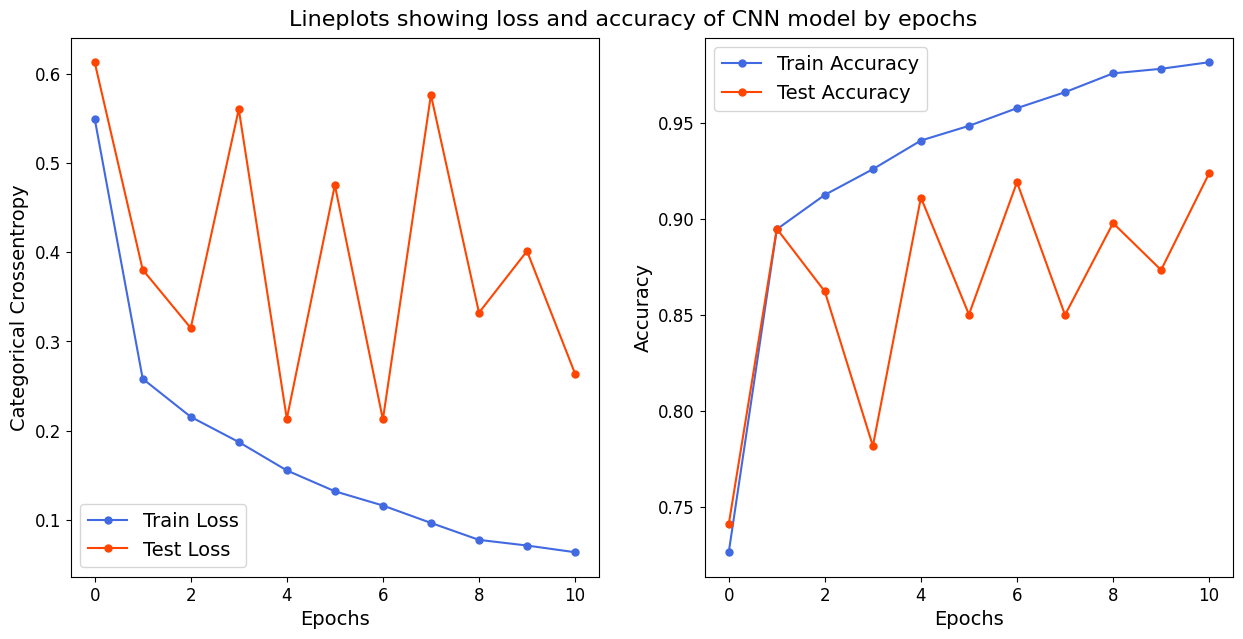

In [ ]:
# Checking the train and test loss and accuracy values from the neural network.
train_loss = save.history['loss']
test_loss = save.history['val_loss']
train_accuracy = save.history['accuracy']
test_accuracy = save.history['val_accuracy']

# Plotting a line chart to visualize the loss and accuracy values by epochs.
fig, ax = plt.subplots(ncols=2, figsize=(15,7))
ax = ax.ravel()
ax[0].plot(train_loss, label='Train Loss', color='royalblue', marker='o', markersize=5)
ax[0].plot(test_loss, label='Test Loss', color = 'orangered', marker='o', markersize=5)
ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Categorical Crossentropy', fontsize=14)
ax[0].legend(fontsize=14)
ax[0].tick_params(axis='both', labelsize=12)
ax[1].plot(train_accuracy, label='Train Accuracy', color='royalblue', marker='o', markersize=5)
ax[1].plot(test_accuracy, label='Test Accuracy', color='orangered', marker='o', markersize=5)
ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)
ax[1].legend(fontsize=14)
ax[1].tick_params(axis='both', labelsize=12)
fig.suptitle(x=0.5, y=0.92, t="Lineplots showing loss and accuracy of CNN model by epochs", fontsize=16)

In [ ]:
model.save("model.h5")

In [ ]:
# Menyimpan model dalam format SavedModel
export_dir = 'saved_model/'
tf.saved_model.save(model, export_dir)

# Convert SavedModel menjadi gender.tflite
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

tflite_model_file = pathlib.Path('gender.tflite')
tflite_model_file.write_bytes(tflite_model)

122376312